# Informe para la optimización de gastos de marketing

Con el propósito de eficientar los datos de marketing de Y.Afisha, se ha creado el presente reporte, que pretende analizar diversas métricas que indicarán tanto el estado del negocio como los efectos de los gastos de Marketing sobre este.

A continuación se enlistas los distintos apartados del reporte:

* 1 - Carga de archivo e inspección inicial de información
* 2 - Preparación de los datos
* 3 - Análisis de los datos
* 4 - Conclusiones generales

# 1 - Carga de archivos e inspección inicial de información

Antes que nada se cargarán las librerías a ser utilizadas, posteriormente, se realizará la carga de los documentos donde se encuentran los datos a ser trabajados y se obtendrá la información de estos mismos para comenzar a tener una idea sobre cómo será necesario limpiar la información.

In [245]:
#Importación de librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [246]:
#Importación de archivos csv

visitas = pd.read_csv('/datasets/visits_log_us.csv')
pedidos = pd.read_csv('/datasets/orders_log_us.csv')
gastos = pd.read_csv('/datasets/costs_us.csv')

In [247]:
#Función para obtener información

def mostrar_info(db):
    db.info()
    display(db.head())
    print('Duplicadas: ', db.duplicated(keep=False).sum())
    print('Valores faltantes: ', db.isnull().sum().sum())
    
    
#Obtención de información referente a la base de visitas
mostrar_info(visitas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Duplicadas:  0
Valores faltantes:  0


En cuanto a esta base, los datos se encuentran completos, sin embargo, va a ser necesario modificar los nombres de las columnas a unos que correspondan a las mejores prácticas, modificar las columnas de tiempos a tipo DateTime, para su correcto procesamiento y se realizará una revisión de la columna Device para confirmar que no existan duplicados por mala captura. Además de esto podemos observar que existen usuarios, como los de las lineas 2 y 4 que inician y terminan una sesión exactamente al mismo tiempo, lo cual no deberíamos estar considerando, ya que no hacen uso realmente de la plataforma, será importante informar posteriormente al área de TI para que revise porqué se están dando estos casos.

In [248]:
#Obtención de información referente a la base de pedidos
mostrar_info(pedidos)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Duplicadas:  0
Valores faltantes:  0


Nuevamente, los datos se encuentran completos, pero igualmente va a ser necesario modificar los nombres de las columnas y el tipo de datos de la columna relacionada con el tiempo del pedido, para su correcto procesamiento.

In [249]:
#Obtención de información referente a la base de gastos de márketing
mostrar_info(gastos)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Duplicadas:  0
Valores faltantes:  0


Una última vez nos encontramos con los datos completos, pero para esta última base sólo hará falta cambiar el tipo de la columna dt.

# 2 Preparación de los datos

Comenzaremos cambiando los nombres de las columnas a unos que respeten las mejores prácticas: minúsculas y con guión-bajo en los espacios. Posteriormente cambiaremos el tipo de las columnas que se encuentren como "Objet" en lugar de tener el tipo "DateTime". Una vez terminado esto, revisaremos los valores distintos de las columna "Device" para confirmar que no existan duplicados. Y finalmente eliminaremos de la base de visitas todas aquellas sesiones que no duraron ni un minuto.

In [250]:
#Convertimos nombres de columnas a minúsculas

visitas.columns = visitas.columns.str.lower()
pedidos.columns = pedidos.columns.str.lower()

#Sustituimos los espacios por guión bajo "_"
    
visitas.columns = visitas.columns.str.replace(' ','_')
pedidos.columns = pedidos.columns.str.replace(' ','_')

print(visitas.columns)
print(pedidos.columns)

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')
Index(['buy_ts', 'revenue', 'uid'], dtype='object')


In [251]:
#Cambiar tipos de columnas a datetime

visitas['end_ts'] = pd.to_datetime(visitas['end_ts'], format='%Y-%m-%d %H:%M:%S')
visitas['start_ts'] = pd.to_datetime(visitas['start_ts'], format='%Y-%m-%d %H:%M:%S')
pedidos['buy_ts'] = pd.to_datetime(pedidos['buy_ts'], format='%Y-%m-%d %H:%M:%S')
gastos['dt'] = pd.to_datetime(gastos['dt'], format='%Y-%m-%d')

#Observar rangos para cada una

def rangos_fecha(col):
    print('Rango para ', col.name, ':')
    print(col.min(),' - ', col.max())
    print()

rangos_fecha(visitas['end_ts'])
rangos_fecha(visitas['start_ts'])
rangos_fecha(pedidos['buy_ts'])
rangos_fecha(gastos['dt'])

Rango para  end_ts :
2017-06-01 00:02:00  -  2018-06-01 01:26:00

Rango para  start_ts :
2017-06-01 00:01:00  -  2018-05-31 23:59:00

Rango para  buy_ts :
2017-06-01 00:10:00  -  2018-06-01 00:02:00

Rango para  dt :
2017-06-01 00:00:00  -  2018-05-31 00:00:00



Podemos observar que los cambios en los tipos de datos por columna se realizaron de manera satisfactoria y que nuestra información ronda entre el primer instante del 1/6/2017 y las primeras horas del 1/6/2018.

In [252]:
#Revisar valores únicos de columna 'device'

display(visitas.groupby('device')['end_ts'].count())

device
desktop    262567
touch       96833
Name: end_ts, dtype: int64

Confirmamos que los datos de la columna Device se encuentran correctamente capturados y una clara preferencia a buscar el sitio en un equipo de escritorio.

A continuación observaremos la distribución de algunas de las principales variables numéricas:

In [253]:
display(pedidos['revenue'].describe())
print()
display(gastos['costs'].describe())

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

count    2542.000000
mean      129.477427
std       156.296628
min         0.540000
25%        21.945000
50%        77.295000
75%       170.065000
max      1788.280000
Name: costs, dtype: float64

Observamos que el ingreso por pedido medio ronda los 5 dólares, cubre más que el 75% de los registros, pero se aleja demasiado del máximo; lo cual nos indicaría la presencia de valores atípicos bastante elevados. Igualmente resulta notable el mínimo de 0, indicando la existencia de promociones o algún tipo de descargable gratuito que pasa por el proceso de compra.

En cuanto a los gastos, encontramos una mayor diversidad, con la media más cercana a la mediana, y ambas considerablemente lejanas del máximo. Esto apoya la importancia de estudiar los efectos de estos gastos, ya que hay fuentes en las que se está invirtiendo demasiado.

Finalmente volveremos a revisar la información sobre las distintas bases para corroborar los cambios realizados:

In [254]:
#Eliminar sesiones que no tienen duración

visitas = visitas.loc[~(visitas['start_ts']==visitas['end_ts'])].reset_index(drop=True)

In [255]:
mostrar_info(visitas)
print()
print()
mostrar_info(pedidos)
print()
print()
mostrar_info(gastos)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323606 entries, 0 to 323605
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     323606 non-null  object        
 1   end_ts     323606 non-null  datetime64[ns]
 2   source_id  323606 non-null  int64         
 3   start_ts   323606 non-null  datetime64[ns]
 4   uid        323606 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 12.3+ MB


,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
3,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
4,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451


Duplicadas:  0
Valores faltantes:  0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Duplicadas:  0
Valores faltantes:  0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Duplicadas:  0
Valores faltantes:  0


Con la información, ya de la manera correcta, procederemos con el análisis correspondiente al estado de la empresa y los gastos de marketing.

# 3 Análisis de los datos

## Producto

Comenzando por entender la naturaleza del producto procederemos a responder las siguientes preguntas:

* ¿Cuántas personas lo usan cada día, semana y mes?
* ¿Cuántas sesiones hay por día?
* ¿Cuál es la duración de cada sesión?
* ¿Con qué frecuencia los usuarios regresan? (para este caso sólo se considerarán a usuarios que regresan, ya que aquellos que ingresan sólo por curiosidad podrían afectar considerablemente el resultado)

Para la primera pregunta, "Cuántas personas lo usan cada día, semana y mes?", procederemos a crear una columna que contenga únicamente la fecha:

In [256]:
#Crear nuevas columnas para día
visitas['date'] = visitas['start_ts'].dt.date

In [257]:
visitas

,device,end_ts,source_id,start_ts,uid,date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19
2,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20
3,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03
4,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018-01-30
...,...,...,...,...,...,...
323601,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-29
323602,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-25
323603,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-03
323604,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-02


Usuarios promedio al día general:  817.5851648351648

Usuarios promedio al día por dispositivo:
    device   ususarios    sesiones
0  desktop  599.752747  656.258242
1    touch  221.460055  233.410468

Usuarios promedio al día por fuente:
   source_id   ususarios    sesiones
0          1   76.043956   88.313187
1          2  110.099174  119.746556
2          3  208.349862  210.977961
3          4  246.041322  250.402204
4          5  156.595041  163.966942
5          6    1.000000    1.000000
6          7    1.060606    1.060606
7          9   32.586777   33.002755
8         10   23.203857   24.713499

Usuarios al día por fuente:
source_id    1    2    3    4    5   6   7   9    10
start_ts                                            
2017-06-01   67   81  162  123  109   0   0  48    9
2017-06-02   57   90  158  146  111   0   0  14   20
2017-06-03   39   54  113  102   82   0   0  16   23
2017-06-04   50   47  123  102   94   0   0  14   17
2017-06-05   79  101  239  156  129   0   0 

<AxesSubplot:title={'center':'Usuarios al día por fuente'}, xlabel='start_ts'>

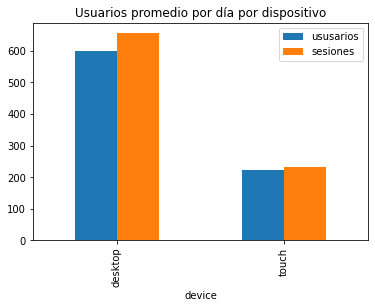

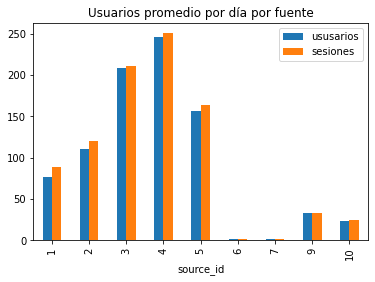

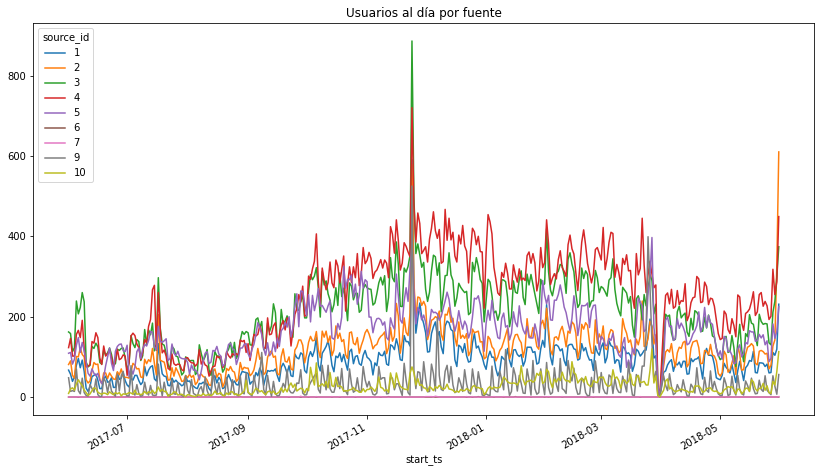

In [258]:
#Usuarios y sesiones promedio por día
print('Usuarios promedio al día general: ', visitas.groupby('date').agg({'uid':'nunique'})['uid'].mean())
print()
visitas_por_dia_device=visitas.pivot_table(index=['date','device'], values='uid', aggfunc=['nunique','count']).reset_index().groupby('device').agg({('nunique', 'uid'):'mean',('count', 'uid'):'mean'}).reset_index()
visitas_por_dia_device.columns=visitas_por_dia_device.columns.droplevel(1)
visitas_por_dia_device=visitas_por_dia_device.groupby('device').agg({'nunique':'mean','count':'mean'}).reset_index().rename(columns={'nunique':'ususarios','count':'sesiones'})
visitas_por_dia_source=visitas.pivot_table(index=['date','source_id'], values='uid', aggfunc=['nunique','count']).reset_index().groupby('source_id').agg({('nunique', 'uid'):'mean',('count', 'uid'):'mean'}).reset_index()
visitas_por_dia_source.columns=visitas_por_dia_source.columns.droplevel(1)
visitas_por_dia_source=visitas_por_dia_source.groupby('source_id').agg({'nunique':'mean','count':'mean'}).reset_index().rename(columns={'nunique':'ususarios','count':'sesiones'})

print('Usuarios promedio al día por dispositivo:')
print(visitas_por_dia_device)
visitas_por_dia_device.plot(x='device',
            kind='bar',
            stacked=False,
            title='Usuarios promedio por día por dispositivo')
print()
print('Usuarios promedio al día por fuente:')
print(visitas_por_dia_source)
visitas_por_dia_source.plot(x='source_id',
            kind='bar',
            stacked=False,
            title='Usuarios promedio por día por fuente')
print()
print('Usuarios al día por fuente:')
users_day_source=np.transpose(visitas.groupby(['source_id', pd.Grouper(freq='D', key='start_ts')])
             ['uid']
             .count()
             .unstack(fill_value=0))
print(users_day_source)
users_day_source.plot(title='Usuarios al día por fuente', figsize=(14,8))

Usuarios promedio a la semana general:  5148.301886792453

Usuarios promedio a la semana por dispositivo:
    device    ususarios     sesiones
0  desktop  3756.773585  4507.132075
1    touch  1433.981132  1598.641509

Usuarios promedio a la semana por fuente:
   source_id    ususarios     sesiones
0          1   437.792453   606.528302
1          2   653.547170   820.150943
2          3  1401.754717  1445.000000
3          4  1636.075472  1715.018868
4          5  1040.773585  1123.018868
5          6     1.000000     1.000000
6          7     1.346154     1.346154
7          9   215.773585   226.037736
8         10   148.358491   169.264151

Usuarios a la semana por fuente:
source_id    1    2     3     4    5   6   7    9    10
start_ts                                               
2017-06-04  213  272   556   473  396   0   0   92   69
2017-06-11  440  607  1328   933  785   0   1  158  171
2017-06-18  273  432   753   839  369   0   0  118   96
2017-06-25  268  367   722   719  61

<AxesSubplot:title={'center':'Usuarios a la semana por fuente'}, xlabel='start_ts'>

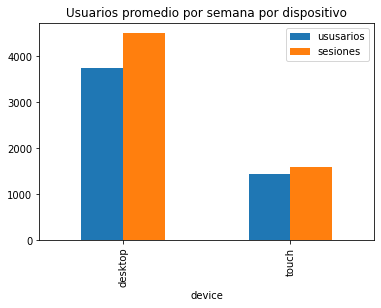

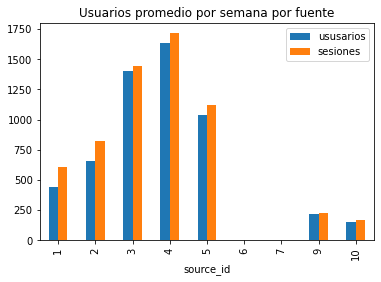

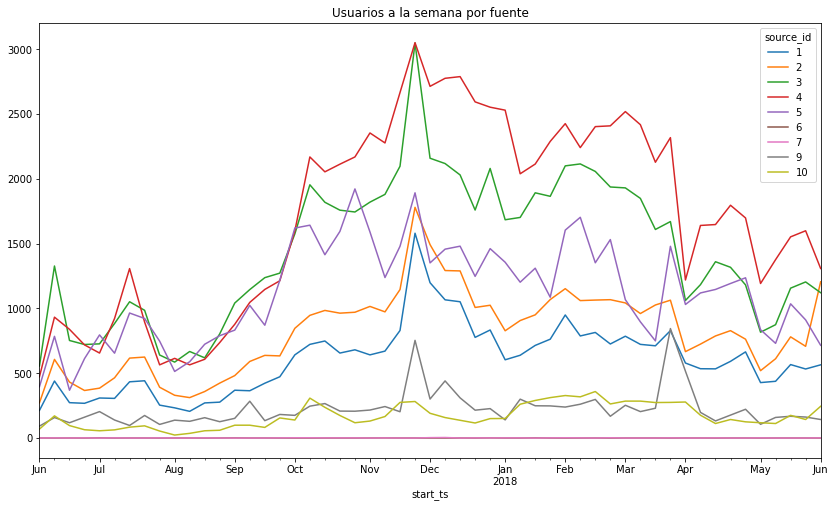

In [259]:
#Usuarios y sesiones promedio por semana
print('Usuarios promedio a la semana general: ', visitas.groupby(pd.Grouper(freq='W', key='start_ts')).agg({'uid':'nunique'})['uid'].mean())
print()
visitas_por_semana_device=visitas.pivot_table(index=[pd.Grouper(freq='W', key='start_ts'),'device'], values='uid', aggfunc=['nunique','count']).reset_index().groupby('device').agg({('nunique', 'uid'):'mean',('count', 'uid'):'mean'}).reset_index()
visitas_por_semana_device.columns=visitas_por_semana_device.columns.droplevel(1)
visitas_por_semana_device=visitas_por_semana_device.groupby('device').agg({'nunique':'mean','count':'mean'}).reset_index().rename(columns={'nunique':'ususarios','count':'sesiones'})
visitas_por_semana_source=visitas.pivot_table(index=[pd.Grouper(freq='W', key='start_ts'), 'source_id'], values='uid', aggfunc=['nunique','count']).reset_index().groupby('source_id').agg({('nunique', 'uid'):'mean',('count', 'uid'):'mean'}).reset_index()
visitas_por_semana_source.columns=visitas_por_semana_source.columns.droplevel(1)
visitas_por_semana_source=visitas_por_semana_source.groupby('source_id').agg({'nunique':'mean','count':'mean'}).reset_index().rename(columns={'nunique':'ususarios','count':'sesiones'})

print('Usuarios promedio a la semana por dispositivo:')
print(visitas_por_semana_device)
visitas_por_semana_device.plot(x='device',
            kind='bar',
            stacked=False,
            title='Usuarios promedio por semana por dispositivo')
print()
print('Usuarios promedio a la semana por fuente:')
print(visitas_por_semana_source)
visitas_por_semana_source.plot(x='source_id',
            kind='bar',
            stacked=False,
            title='Usuarios promedio por semana por fuente')
print()
print('Usuarios a la semana por fuente:')
users_week_source=np.transpose(visitas.groupby(['source_id', pd.Grouper(freq='W', key='start_ts')])
             ['uid']
             .count()
             .unstack(fill_value=0))
print(users_week_source.head(10))
users_week_source.plot(title='Usuarios a la semana por fuente', figsize=(14,8))

Usuarios promedio al mes general:  20955.75

Usuarios promedio al mes por dispositivo:
    device     ususarios      sesiones
0  desktop  15239.916667  19906.500000
1    touch   5999.166667   7060.666667

Usuarios promedio al mes por fuente:
   source_id    ususarios     sesiones
0          1  1718.416667  2678.833333
1          2  2517.333333  3622.333333
2          3  6055.083333  6382.083333
3          4  6955.916667  7574.666667
4          5  4474.333333  4960.000000
5          6     1.000000     1.000000
6          7     2.750000     2.916667
7          9   894.833333   998.333333
8         10   630.083333   747.583333

Usuarios al mes por fuente:
source_id     1     2     3      4     5   6   7     9     10
start_ts                                                     
2017-06-30  1448  1967  3934   3479  2780   0   2   727   437
2017-07-31  1543  2249  3815   3929  3565   1   2   574   315
2017-08-31  1175  1670  3200   2960  3030   1   1   628   247
2017-09-30  1972  2786  5455 

<AxesSubplot:title={'center':'Usuarios al mes por fuente'}, xlabel='start_ts'>

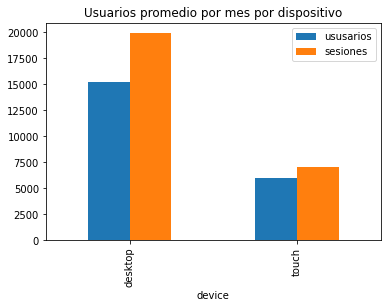

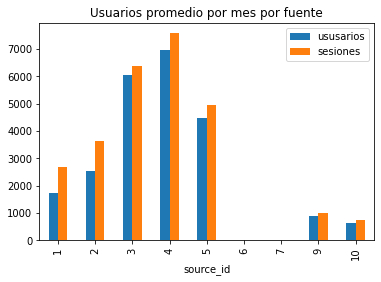

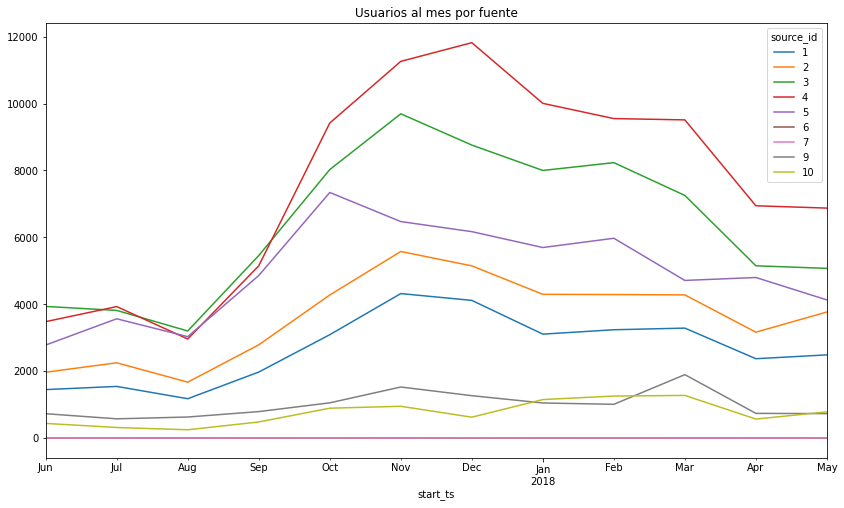

In [260]:
#Usuarios y sesiones promedio por mes
print('Usuarios promedio al mes general: ', visitas.groupby(pd.Grouper(freq='1M', key='start_ts')).agg({'uid':'nunique'})['uid'].mean())
print()
visitas_por_mes_device=visitas.pivot_table(index=[pd.Grouper(freq='1M', key='start_ts'),'device'], values='uid', aggfunc=['nunique','count']).reset_index().groupby('device').agg({('nunique', 'uid'):'mean',('count', 'uid'):'mean'}).reset_index()
visitas_por_mes_device.columns=visitas_por_mes_device.columns.droplevel(1)
visitas_por_mes_device=visitas_por_mes_device.groupby('device').agg({'nunique':'mean','count':'mean'}).reset_index().rename(columns={'nunique':'ususarios','count':'sesiones'})
visitas_por_mes_source=visitas.pivot_table(index=[pd.Grouper(freq='1M', key='start_ts'),'source_id'], values='uid', aggfunc=['nunique','count']).reset_index().groupby('source_id').agg({('nunique', 'uid'):'mean',('count', 'uid'):'mean'}).reset_index()
visitas_por_mes_source.columns=visitas_por_mes_source.columns.droplevel(1)
visitas_por_mes_source=visitas_por_mes_source.groupby('source_id').agg({'nunique':'mean','count':'mean'}).reset_index().rename(columns={'nunique':'ususarios','count':'sesiones'})

print('Usuarios promedio al mes por dispositivo:')
print(visitas_por_mes_device)
visitas_por_mes_device.plot(x='device',
            kind='bar',
            stacked=False,
            title='Usuarios promedio por mes por dispositivo')
print()
print('Usuarios promedio al mes por fuente:')
print(visitas_por_mes_source)
visitas_por_mes_source.plot(x='source_id',
            kind='bar',
            stacked=False,
            title='Usuarios promedio por mes por fuente')
print()
print('Usuarios al mes por fuente:')
users_month_source=np.transpose(visitas.groupby(['source_id', pd.Grouper(freq='1M', key='start_ts')])
             ['uid']
             .count()
             .unstack(fill_value=0))
print(users_month_source)
users_month_source.plot(title='Usuarios al mes por fuente', figsize=(14,8))

A partir de estas primeras comparaciones entre las sesiones y los usuarios, por dispositivo y por fuente, podemos observar lo siguiente:

* Una clara preferencia por el uso de equipos de escritorio sobre los touch.
* Una clara ventaja de las fuentes 3, 4 y 5 en la captación de usuarios.
* Una muy baja o nula presencia de las fuentes 6 y 7.
* La tendencia de los usuarios a conectarse una vez en cada uno de los periodos de tiempo. Los volúmenes de sesiones son prácticamente iguales al de usuarios distintos conectados.

Sesión promedio en minutos general:  11.901661279457118

Sesión promedio en minutos por dispositivo:
    device  duration_min
0  desktop     12.883007
1    touch      9.134902

Sesión promedio en minutos por fuente:
   source_id  duration_min
0          1     18.385211
1          2     15.424220
2          3     10.661213
3          4     10.448898
4          5      9.867272
5          6     27.400000
6          7     10.400000
7          9     10.454758
8         10     12.337198


<AxesSubplot:title={'center':'Minutos de sesión promedio por fuente'}, xlabel='source_id'>

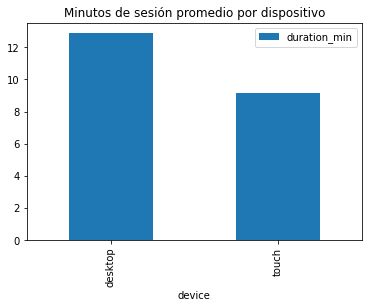

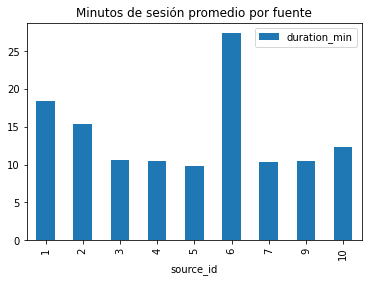

In [261]:
#¿Cuál es la duración de cada sesión?

visitas['duration_min']=(visitas['end_ts']-visitas['start_ts']).astype('timedelta64[m]').astype('int')

print('Sesión promedio en minutos general: ', visitas['duration_min'].mean())
print()

minutos_por_disp = visitas.groupby('device').agg({'duration_min':'mean'}).reset_index()
minutos_por_fuente = visitas.groupby('source_id').agg({'duration_min':'mean'}).reset_index()

print('Sesión promedio en minutos por dispositivo:')
print(minutos_por_disp)
minutos_por_disp.plot(x='device',
            kind='bar',
            stacked=False,
            title='Minutos de sesión promedio por dispositivo')
print()
print('Sesión promedio en minutos por fuente:')
print(minutos_por_fuente)
minutos_por_fuente.plot(x='source_id',
            kind='bar',
            stacked=False,
            title='Minutos de sesión promedio por fuente')

Podemos observar que existe una clara tendencia alrrededor de los 10 minutos independientemente de la fuente y casi igualmente del dispositivo, sin embargo, existe una excepción en la fuente 6 con una media de 27. Esta excepción coincide con la prácticamente nula presencia de esta fuente en las visitas, lo cual denota que en efecto debe ser tratado como un caso extraño y sería necesario revisar si la sesión inusualmente larga se debió a problemas con la fuente, mismos que ocasionaran su poco uso.

A continuación analizaremos el comportamiento en general de la variable y realizaremos un histograma que nos permita comprender su comportamiento.

count    323606.000000
mean         11.901661
std          17.106831
min         -46.000000
25%           2.000000
50%           6.000000
75%          15.000000
max         711.000000
Name: duration_min, dtype: float64

count    323500.000000
mean         11.802012
std          16.093677
min           0.000000
25%           2.000000
50%           6.000000
75%          15.000000
max         240.000000
Name: duration_min, dtype: float64

Histograma de sesiones:


(array([137402.,  64317.,  35872.,  24084.,  18101.,  14070.,   7723.,
          5224.,   3726.,   2798.,   2201.,   1523.,   1209.,    964.,
           787.,    661.]),
 array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]),
 <BarContainer object of 16 artists>)

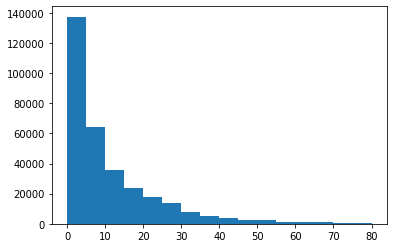

In [262]:
#Comportamiento de la duración

print(visitas['duration_min'].describe())

print()

#Eliminamos registros de valores negativos, lo cual debe tratarse de un error en la obtención de los datos,
#así como de los valores de más de cuatro horas que pueden indicar errores y sesiones olvidadas

visitas = visitas.loc[visitas['duration_min'] > -1]
visitas = visitas.loc[visitas['duration_min'] < 241]

print(visitas['duration_min'].describe())

print()

#Al observar que tanto el negativo son excepciones y que el 75% de los valores se encuentran debajo de 15,
#Se ralizará el análisis sobre un fragmento de la información

print('Histograma de sesiones:')
plt.hist(visitas['duration_min'],
            stacked=False, bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80])

Podemos observar en el histograma claramente un sesgo positivo, indicando que entre más largas son las sesiones, son mucho menos frecuentes. Y esto puede corroborarse al encontrar en la descripción una media mucho mayor que la mediana, casi el doble, así como con la distribución estandar que al ser mayor que la media (con un minimo lógico de 0), indica un rango muy amplio para la ubicación de los eventos. Igualmente es relevante mencionar que sólo 106 registros fueron perdidos en la eliminación de excepciones de los 323606 registros previos, lo cual representa el 0.0003%.

                         uid   device  source_id  count                 min  \
0             11863502262781    touch          3      1 2018-03-01 17:27:00   
1             49537067089222    touch          2      1 2018-02-06 15:55:00   
2            297729379853735  desktop          3      1 2017-06-07 18:47:00   
3            313578113262317  desktop          2      3 2017-09-18 22:49:00   
4            325320750514679  desktop          5      2 2017-09-30 14:29:00   
...                      ...      ...        ...    ...                 ...   
254780  18446316582013423015  desktop          3      1 2018-02-26 10:14:00   
254781  18446403737806311543  desktop          5      1 2017-11-30 03:36:00   
254782  18446556406699109058    touch          3      1 2018-01-01 16:29:00   
254783  18446621818809592527  desktop          4      2 2017-12-27 13:27:00   
254784  18446676030785672386  desktop          3      1 2017-10-04 16:01:00   

                       max         return  
0      

<AxesSubplot:title={'center':'Promedio de regreso en días por fuente'}, xlabel='source_id'>

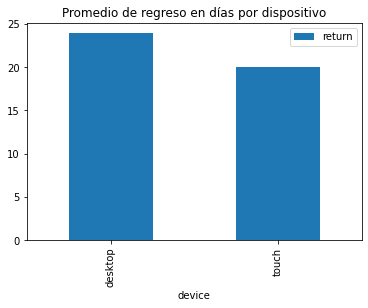

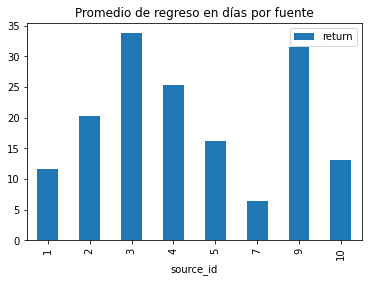

In [263]:
#¿Con qué frecuencia los usuarios regresan?

visitas_by_uid = visitas.pivot_table(index=['uid','device','source_id'], values='start_ts', aggfunc=['count','min','max']).reset_index()
visitas_by_uid.columns = visitas_by_uid.columns.droplevel(1)
visitas_by_uid['return']=(visitas_by_uid['max']-visitas_by_uid['min']).astype('timedelta64[m]').astype('float')/visitas_by_uid['count']
print(visitas_by_uid)
print('Promedio de regreso en días general: ',visitas_by_uid.loc[visitas_by_uid['return'] > 0]['return'].mean()/60/24)
print()

return_por_disp = visitas_by_uid.loc[visitas_by_uid['return'] > 0].groupby('device').agg({'return':'mean'}).reset_index()
return_por_disp['return']=return_por_disp['return']/60/24
return_por_fuente = visitas_by_uid.loc[visitas_by_uid['return'] > 0].groupby('source_id').agg({'return':'mean'}).reset_index()
return_por_fuente['return']=return_por_fuente['return']/60/24


print('Promedio de regreso en días por dispositivo:')
print(return_por_disp)
return_por_disp.plot(x='device',
            kind='bar',
            stacked=False,
            title='Promedio de regreso en días por dispositivo')
print()
print('Promedio de regreso en días por fuente:')
print(return_por_fuente)
return_por_fuente.plot(x='source_id',
            kind='bar',
            stacked=False,
            title='Promedio de regreso en días por fuente')

El promedio de retorno es indistinto prácticamente entre los dispositivos, más no es así en las fuentes. De la fuente 6 confirmando nuestras conclusiones del punto anterior, en efecto no cuenta con un indice de retorno reiterando que se trata de una excepción. Debe estudiarse más a detalle la inversión en las fuentes para poder determinar si estos índices de retorno tienen sentido dados los gastos de marketing por fuente.

A continuación dividiremos a los usuarios en cohortes respecto a la primera fecha de inicio de sesión y veremos, a partir de este dato, su tendencia de retorno.

In [264]:
#Obtención de la primer fecha por usuario

visitas_primer_inicio = visitas.groupby('uid')['date'].min()
visitas_primer_inicio.name = 'first_date'

display(visitas_primer_inicio.head())

uid
11863502262781     2018-03-01
49537067089222     2018-02-06
297729379853735    2017-06-07
313578113262317    2017-09-18
325320750514679    2017-09-30
Name: first_date, dtype: object

Y procedemos a unir estos datos con la base inicial de visitas

In [265]:
#Unión de la serie con la db

visitas = visitas.join(visitas_primer_inicio,on='uid')
display(visitas.head(10))

,device,end_ts,source_id,start_ts,uid,date,duration_min,first_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,18,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,28,2018-02-19
2,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,24,2018-03-09
3,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,1,2017-09-03
4,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018-01-30,56,2017-06-29
5,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312,2017-11-05,1,2017-11-05
6,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644,2017-07-19,3,2017-07-19
7,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063,2017-11-08,1,2017-11-08
8,desktop,2017-07-14 12:44:00,5,2017-07-14 12:43:00,14879997728223227242,2017-07-14,1,2017-07-14
9,desktop,2018-01-25 19:41:00,1,2018-01-25 19:37:00,7478054213403174082,2018-01-25,4,2018-01-25


In [266]:
#Obtenemos columnas para los meses

visitas['first_date_month'] = visitas['first_date'].astype(
    'datetime64[M]'
)
visitas['date_month'] = visitas['date'].astype('datetime64[M]')
display(visitas.head(10)) 

,device,end_ts,source_id,start_ts,uid,date,duration_min,first_date,first_date_month,date_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,18,2017-12-20,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,28,2018-02-19,2018-02-01,2018-02-01
2,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,24,2018-03-09,2018-03-01,2018-05-01
3,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,1,2017-09-03,2017-09-01,2017-09-01
4,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018-01-30,56,2017-06-29,2017-06-01,2018-01-01
5,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312,2017-11-05,1,2017-11-05,2017-11-01,2017-11-01
6,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644,2017-07-19,3,2017-07-19,2017-07-01,2017-07-01
7,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063,2017-11-08,1,2017-11-08,2017-11-01,2017-11-01
8,desktop,2017-07-14 12:44:00,5,2017-07-14 12:43:00,14879997728223227242,2017-07-14,1,2017-07-14,2017-07-01,2017-07-01
9,desktop,2018-01-25 19:41:00,1,2018-01-25 19:37:00,7478054213403174082,2018-01-25,4,2018-01-25,2018-01-01,2018-01-01


Con esta información ya va a ser posible agrupar por cohortes:

In [267]:
#Agrupación de los cohortes por primera sesión y sesión

cohort_grouped_visitas = visitas.groupby(
    ['first_date_month', 'date_month']
).agg({'uid': 'nunique','end_ts':'count'})

display(cohort_grouped_visitas.head(15))

uid  end_ts
first_date_month date_month               
2017-06-01       2017-06-01  11885   14763
                 2017-07-01    900    2135
                 2017-08-01    606    1555
                 2017-09-01    710    2004
                 2017-10-01    777    2352
                 2017-11-01    802    2626
                 2017-12-01    686    2354
                 2018-01-01    667    1946
                 2018-02-01    606    1864
                 2018-03-01    591    1770
                 2018-04-01    453    1419
                 2018-05-01    522    1441
2017-07-01       2017-07-01  11825   13845
                 2017-08-01    645    1029
                 2017-09-01    596    1044

In [268]:
#Obtendremos un promedio de sesiones al mes por usuario dividiendo el total de sesiones entre el total de usuarios de cada mes

cohort_grouped_visitas['sesiones_por_usuario_mes'] = (
    cohort_grouped_visitas['end_ts']
    / cohort_grouped_visitas['uid'])

display(cohort_grouped_visitas.head(15))

uid  end_ts  sesiones_por_usuario_mes
first_date_month date_month                                         
2017-06-01       2017-06-01  11885   14763                  1.242154
                 2017-07-01    900    2135                  2.372222
                 2017-08-01    606    1555                  2.566007
                 2017-09-01    710    2004                  2.822535
                 2017-10-01    777    2352                  3.027027
                 2017-11-01    802    2626                  3.274314
                 2017-12-01    686    2354                  3.431487
                 2018-01-01    667    1946                  2.917541
                 2018-02-01    606    1864                  3.075908
                 2018-03-01    591    1770                  2.994924
                 2018-04-01    453    1419                  3.132450
                 2018-05-01    522    1441                  2.760536
2017-07-01       2017-07-01  11825   13845                  1.170825
                 2017-08-01    645    1029                  1.595349
                 2017-09-01    596    1044                  1.751678

A continuación, para obtener una lectura más clara de los datos, crearemos una columna de ciclo de vida, para observar los cambios sobre el tiempo transcurrido para cada cohorte.

In [269]:
#Creación de la columna lifetime

cohort_grouped_visitas = cohort_grouped_visitas.reset_index()
cohort_grouped_visitas['cohort_lifetime'] = (
    cohort_grouped_visitas['date_month']
    - cohort_grouped_visitas['first_date_month']
)/ np.timedelta64(1, 'M')

#Redondeamos por el factor de mes que crea decimales
cohort_grouped_visitas['cohort_lifetime'] = (
    cohort_grouped_visitas['cohort_lifetime'].round().astype('int')
)

display(cohort_grouped_visitas.head(15))

,first_date_month,date_month,uid,end_ts,sesiones_por_usuario_mes,cohort_lifetime
0,2017-06-01,2017-06-01,11885,14763,1.242154,0
1,2017-06-01,2017-07-01,900,2135,2.372222,1
2,2017-06-01,2017-08-01,606,1555,2.566007,2
3,2017-06-01,2017-09-01,710,2004,2.822535,3
4,2017-06-01,2017-10-01,777,2352,3.027027,4
5,2017-06-01,2017-11-01,802,2626,3.274314,5
6,2017-06-01,2017-12-01,686,2354,3.431487,6
7,2017-06-01,2018-01-01,667,1946,2.917541,7
8,2017-06-01,2018-02-01,606,1864,3.075908,8
9,2017-06-01,2018-03-01,591,1770,2.994924,9


In [270]:
#Modificamos el formato de las cohortes, para fácil identificación

cohort_grouped_visitas['first_date_month']=cohort_grouped_visitas['first_date_month'].dt.strftime('%Y-%m')

display(cohort_grouped_visitas.head(15))

,first_date_month,date_month,uid,end_ts,sesiones_por_usuario_mes,cohort_lifetime
0,2017-06,2017-06-01,11885,14763,1.242154,0
1,2017-06,2017-07-01,900,2135,2.372222,1
2,2017-06,2017-08-01,606,1555,2.566007,2
3,2017-06,2017-09-01,710,2004,2.822535,3
4,2017-06,2017-10-01,777,2352,3.027027,4
5,2017-06,2017-11-01,802,2626,3.274314,5
6,2017-06,2017-12-01,686,2354,3.431487,6
7,2017-06,2018-01-01,667,1946,2.917541,7
8,2017-06,2018-02-01,606,1864,3.075908,8
9,2017-06,2018-03-01,591,1770,2.994924,9


Finalmente creamos la tabla y la pasamos por un heatmap para su más fácil interpretación

<AxesSubplot:title={'center':'Sesiones promedio por cliente'}, xlabel='cohort_lifetime', ylabel='first_date_month'>

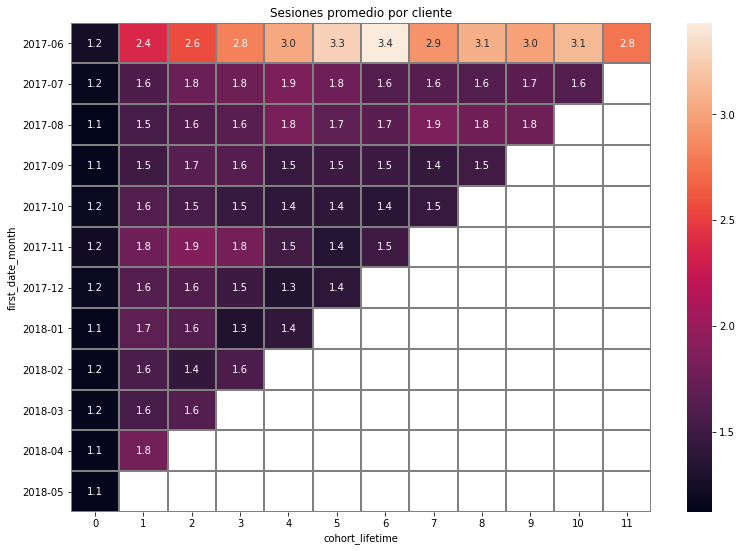

In [271]:
sesiones_por_usuario_pivot = cohort_grouped_visitas.pivot_table(
    index='first_date_month',
    columns='cohort_lifetime',
    values='sesiones_por_usuario_mes',
    aggfunc='mean',
)

plt.figure(figsize=(13, 9))
plt.title('Sesiones promedio por cliente')
sns.heatmap(
    sesiones_por_usuario_pivot,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
) 

Gracias a la gráfica anterior podemos observar claramente que la primer cohorte es una excepción, mientras que el resto se comportan de forma relativamente homóloga, aumentando su uso en el segundo mes manteniendo constante su comportamiento. Igualmente resulta evidente el ligeramente mayor promedio de sesiones para la segunda y tercera cohorte.

El comportamiento de la primera, que prácticamente duplica el resto de las cohortes resulta interesante ya que han experimentado cualquier cambio y promoción que experimentaron las siguientes cohortes, pero su comportamiento es claramente distinto. Esto puede deberse a alguna promoción de entrada a los primeros clientes del servicio que pueden seguir aprovechando mes con mes.

Finalmente, para comprender el comportamiento del volumen de usuarios y, posteriormente a partir de este la retención de los mismos, crearemos un heatmap de la presencia de los mismos mes con mes.

<AxesSubplot:title={'center':'Usuarios al mes'}, xlabel='cohort_lifetime', ylabel='first_date_month'>

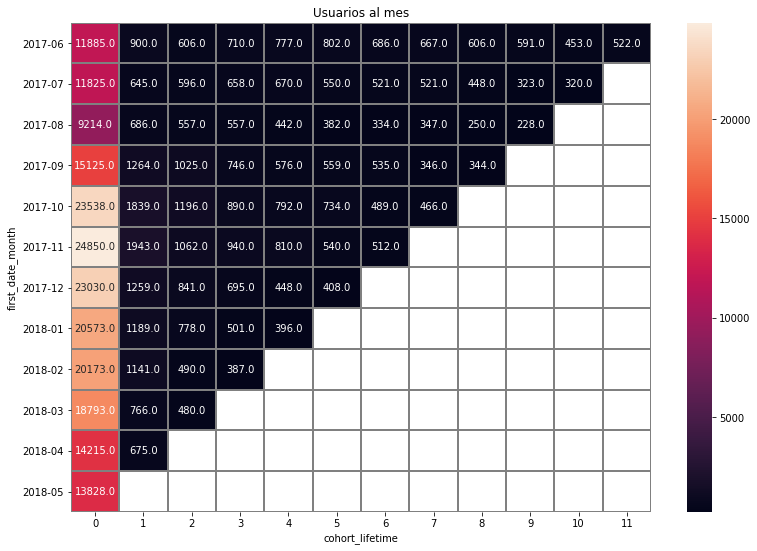

In [272]:
#Heatmap de volumen de usuarios al mes

usuarios_al_mes = cohort_grouped_visitas.pivot_table(
    index='first_date_month',
    columns='cohort_lifetime',
    values='uid',
    aggfunc='mean',
)

plt.figure(figsize=(13, 9))
plt.title('Usuarios al mes')
sns.heatmap(
    usuarios_al_mes,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
) 

El heatmap evidencia claramente que las cohortes son mucho mayores el primer mes, que los meses subsecuentes, a continuación obtendremos la tasa de retención de las mismas dividiendo todas las columnas por la primera, pero obviando la primera columna que destaca sobre el resto evitando que podamos aprovechar las cualidades del mapa de calor.

<AxesSubplot:title={'center':'Tasa de retención (%)'}, xlabel='cohort_lifetime', ylabel='first_date_month'>

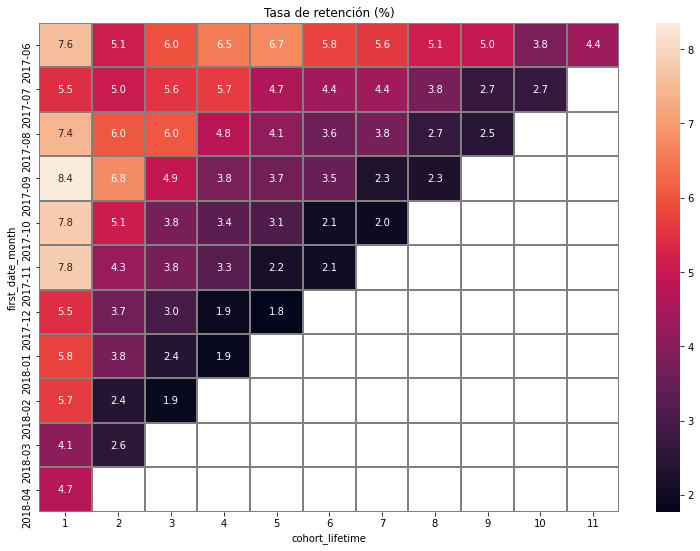

In [273]:
#Calcular tasa de retención y unir a tabla
cohort_grouped_visitas_retention=cohort_grouped_visitas.groupby(['first_date_month','cohort_lifetime']).agg({'uid':'mean'}).reset_index()
first_month_act = cohort_grouped_visitas[cohort_grouped_visitas['cohort_lifetime']==0].groupby(['first_date_month']).agg({'uid':'mean'}).reset_index()
first_month_act.columns = ['first_date_month','first_month_act']
cohort_grouped_visitas_retention_join=pd.merge(cohort_grouped_visitas_retention,first_month_act,on='first_date_month', how='left')
cohort_grouped_visitas_retention_join['tasa_de_retencion']=(cohort_grouped_visitas_retention_join['uid']/cohort_grouped_visitas_retention_join['first_month_act'])*100
cohort_grouped_visitas_retention_join=cohort_grouped_visitas_retention_join[cohort_grouped_visitas_retention_join['cohort_lifetime']!=0]


#Crear pivot table
tasa_retencion = cohort_grouped_visitas_retention_join.pivot_table(
    index='first_date_month',
    columns='cohort_lifetime',
    values='tasa_de_retencion',
    aggfunc='mean',
)

#Crear heatmap
plt.figure(figsize=(13, 9))
plt.title('Tasa de retención (%)')
sns.heatmap(
    tasa_retencion,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
) 

Podemos observar claramente cómo, mes con mes, cohorte por cohorte, la tasa de retención cae más rápidamente, lo que al mismo tiempo significa que hay algo creciente que evita la retención general de clientes en los últimos meses.

## Ventas

Ahora comenzaremos a estudiar un poco más a fondo el negocio entrando a las ventas, ya no importando únicamente que inicien una sesión, sino que realicen una compra. Para este apartado realizaremos las preguntas:

* ¿Cuándo la gente empieza a comprar?
* ¿Cuántos pedidos hacen durante un período de tiempo dado?
* ¿Cuál es el tamaño promedio de compra?
* ¿Cuánto dinero traen? (LTV)

Para la primera pregunta, comenzaremos obteniendo la cantidad de días entre su primer registro y su primera compra. Esto lo visualizaremos finalmente en una matriz para poder determinar en qué rango de fechas desde su primera sesión el usuario genérico realiza su primera compra.

In [274]:
#Crear nueva columna de fecha de compra

pedidos['buy_date'] = pedidos['buy_ts'].dt.date

primera_compra = pedidos.groupby(['uid'])['buy_date'].min()
primera_compra.name = 'primera_compra'
display(primera_compra.head())

uid
313578113262317     2018-01-03
1575281904278712    2017-06-03
2429014661409475    2017-10-11
2464366381792757    2018-01-28
2551852515556206    2017-11-24
Name: primera_compra, dtype: object

In [275]:
#Unión de la serie con la db

pedidos = pedidos.join(primera_compra,on='uid')
display(pedidos.head(10))

,buy_ts,revenue,uid,buy_date,primera_compra
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01,2017-06-01
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01,2017-06-01
7,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01,2017-06-01
8,2017-06-01 09:22:00,3.30,17542070709969841479,2017-06-01,2017-06-01
9,2017-06-01 09:23:00,0.37,1074355127080856382,2017-06-01,2017-06-01


In [276]:
#Unir fecha de primera sesión

pedidos = pedidos.join(visitas_primer_inicio,on='uid')
display(pedidos.head(10))

,buy_ts,revenue,uid,buy_date,primera_compra,first_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01,2017-06-01,2017-06-01
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01,2017-06-01,2017-06-01
7,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01,2017-06-01,2017-06-01
8,2017-06-01 09:22:00,3.30,17542070709969841479,2017-06-01,2017-06-01,2017-06-01
9,2017-06-01 09:23:00,0.37,1074355127080856382,2017-06-01,2017-06-01,2017-06-01


In [277]:
#Obtener tiempo a primera compra

pedidos['dias_a_primera_compra']=(pedidos['primera_compra']-pedidos['first_date'])/ np.timedelta64(1, 'D')

display(pedidos.head(10))

print(pedidos['dias_a_primera_compra'].describe())

,buy_ts,revenue,uid,buy_date,primera_compra,first_date,dias_a_primera_compra
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,0.0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,0.0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,0.0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,0.0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,0.0
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01,2017-06-01,2017-06-01,0.0
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01,2017-06-01,2017-06-01,0.0
7,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01,2017-06-01,2017-06-01,0.0
8,2017-06-01 09:22:00,3.30,17542070709969841479,2017-06-01,2017-06-01,2017-06-01,0.0
9,2017-06-01 09:23:00,0.37,1074355127080856382,2017-06-01,2017-06-01,2017-06-01,0.0


count    49940.000000
mean        16.199039
std         45.366262
min       -328.000000
25%          0.000000
50%          0.000000
75%          3.000000
max        363.000000
Name: dias_a_primera_compra, dtype: float64


Podemos observar que existen valores negativos, evaluemos si son representativos ya que puede tratarse de un error en la captura, ya que no es lógico que alguien comprara antes de visitar el sitio.

In [278]:
#Obtenemos la proporción de usuarios que presentan menos una cifra negativa entre su primera visita y compra

print(pedidos[pedidos['dias_a_primera_compra']<0]['dias_a_primera_compra'].count()/pedidos['dias_a_primera_compra'].count())

0.009711653984781738


Al ser una fracción bastante pequeña de los usuarios procederemos a no considerarla, con el propósito de no trabajar con información contaminada.

In [279]:
#Eliminación de registros erroneos

pedidos = pedidos[pedidos['dias_a_primera_compra']>=0]

pedidos['dias_a_primera_compra'] = pedidos['dias_a_primera_compra'].astype('int')

display(pedidos.head())
print(pedidos['dias_a_primera_compra'].describe())

,buy_ts,revenue,uid,buy_date,primera_compra,first_date,dias_a_primera_compra
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,0


count    49455.000000
mean        16.606147
std         45.135508
min          0.000000
25%          0.000000
50%          0.000000
75%          4.000000
max        363.000000
Name: dias_a_primera_compra, dtype: float64


Ahora obtendremos una primera gráfica de la primera compra, para lo cual utilizaremos un histograma, que nos permita ver su comportamiento.

Histograma de días a primera compra:


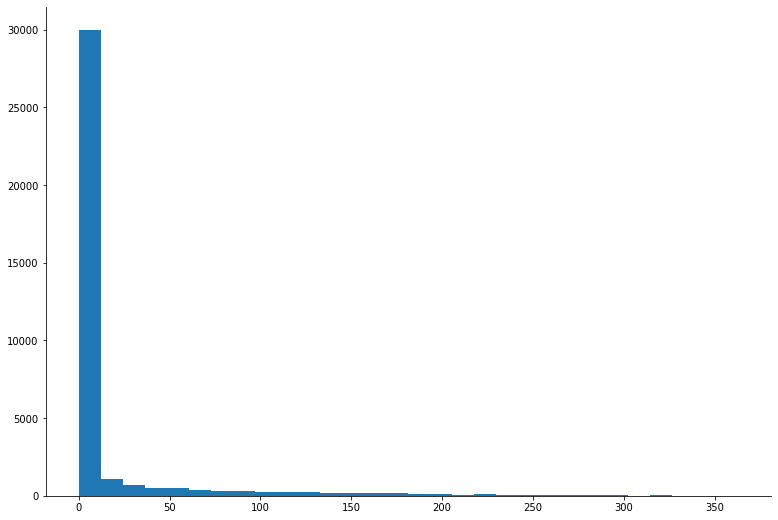

In [280]:
#Obtenemos la información por usuario para no tener duplicados
dias_a_primera_compra_por_usuario = pedidos.groupby(
    ['uid']
).agg({'dias_a_primera_compra': 'mean'})

print('Histograma de días a primera compra:')
plt.figure(figsize=(13, 9))
ax= plt.subplot()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.hist(dias_a_primera_compra_por_usuario['dias_a_primera_compra'], stacked=False, bins=30)
plt.show()

Encontramos una clara tendencia a comprar el mismo día de la visita con una reducción drástica en los primeros días, para poder comprender mejor este comportamiento realizaremos un histograma que considere entre uno y 50 días a la primera compra.

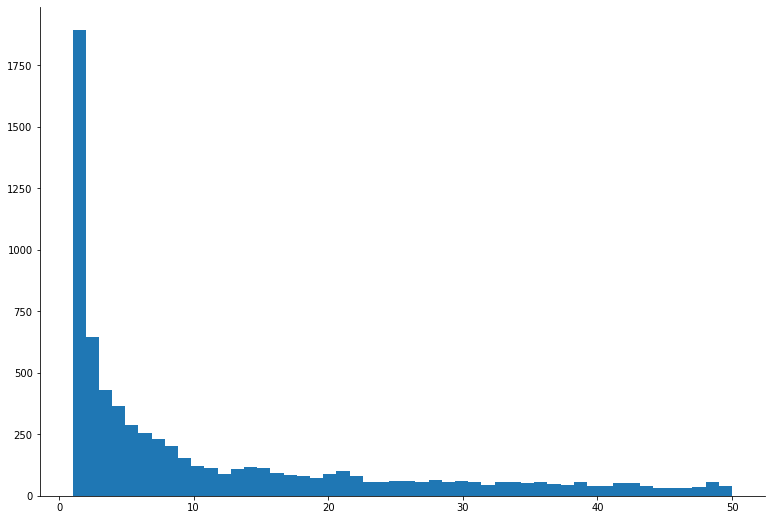

In [281]:
#Porción de gráfica

plt.figure(figsize=(13, 9))
ax= plt.subplot()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.hist(dias_a_primera_compra_por_usuario[(dias_a_primera_compra_por_usuario['dias_a_primera_compra'] > 0) & (dias_a_primera_compra_por_usuario['dias_a_primera_compra'] < 51)]['dias_a_primera_compra'], stacked=False, bins=50)
plt.show()

Confirmamos la drástica caída, donde al primer día de compra baja de alrrededor de 25000 a alrrededor de 1800, para en los próximoa días continuar bajando hasta estabilizarse alrrededor del día 23 y prácticamente desapareciendo después del día 100, como pudo observarse en la gráfica anterior.

A continuación, utilizando las mismas cohortes de primer inicio de sesión, que en el análisis de visitas, obtendremos los tiempos promedio a la primera compra, así como por dispositivo y por fuente.

dias_a_primera_compra       
                                  mean  count
first_date_month                             
2017-06-01                   64.938479  16466
2017-07-01                   60.538561   7702
2017-08-01                   56.126007   5087
2017-09-01                   37.387973   8132
2017-10-01                   24.646009  10811
2017-11-01                   22.286646  11352
2017-12-01                   13.972989   8219
2018-01-01                   11.234675   5889
2018-02-01                    7.704206   5825
2018-03-01                    4.194878   5193
2018-04-01                    3.811881   3232
2018-05-01                    0.901322   3101

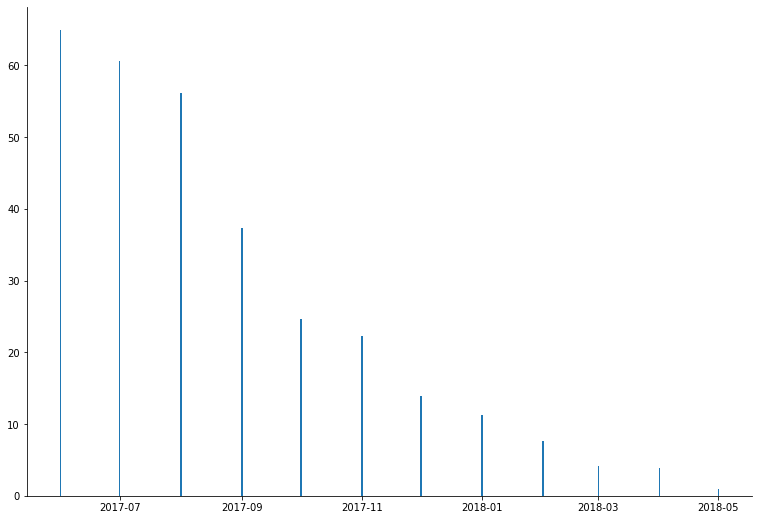

In [282]:
#Tiempo medio por cohorte de inicio de sesión

##Obtenemos la cohorte de nuestra tabla de visitas
dias_a_primera_compra_por_usuario = dias_a_primera_compra_por_usuario.reset_index()
dias_a_primera_compra_por_usuario = pd.merge(dias_a_primera_compra_por_usuario,visitas[['uid','first_date_month']],on='uid', how='left')

display(dias_a_primera_compra_por_usuario.groupby('first_date_month').agg({'dias_a_primera_compra': ['mean','count']}))
plt.figure(figsize=(13, 9))
ax= plt.subplot()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.bar(dias_a_primera_compra_por_usuario.groupby('first_date_month').agg({'dias_a_primera_compra': 'mean'}).reset_index()['first_date_month'],
       dias_a_primera_compra_por_usuario.groupby('first_date_month').agg({'dias_a_primera_compra': 'mean'}).reset_index()['dias_a_primera_compra'])
plt.show()

Podemos observar que el promedio de días a la primera compra se reduce mes con mes, lo cual a pesar de los datos excesivamente altos, se contrarresta con la gran cantidad de primeras compras el mismo día.

Para este mismo cálculo con cohortes por dispositivo consideraremos el primer dispositivo por el que se conectaron.

dias_a_primera_compra       
                         mean  count
device                              
desktop             28.127498  91484
touch               30.111845  21351

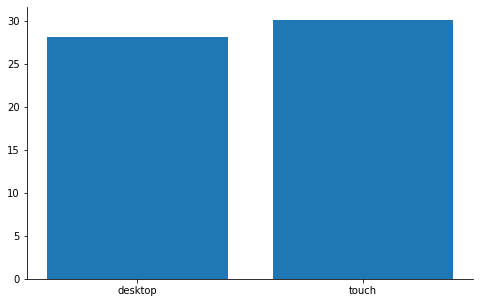

In [283]:
#Tiempo medio por cohorte de dispositivo

dias_a_primera_compra_por_usuario = pd.merge(dias_a_primera_compra_por_usuario,visitas[visitas['first_date']==visitas['date']][['uid','device']], on='uid', how='left')

display(dias_a_primera_compra_por_usuario.groupby('device').agg({'dias_a_primera_compra': ['mean','count']}))
plt.figure(figsize=(8, 5))
ax= plt.subplot()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.bar(dias_a_primera_compra_por_usuario.groupby('device').agg({'dias_a_primera_compra': 'mean'}).reset_index()['device'],
       dias_a_primera_compra_por_usuario.groupby('device').agg({'dias_a_primera_compra': 'mean'}).reset_index()['dias_a_primera_compra'])
plt.show()

En este caso observamos que el tiempo promedio de días a la primera compra es algo independiente al dispositivo, compartiendo ambos el mismo promedio.

Finalmente, al igual que con los dispositivos, se considerará la primera fuente por la que ingresaron los usuarios.

dias_a_primera_compra       
                           mean  count
source_id                             
1                     20.741209  33131
2                     31.623173  30648
3                     28.992476  31765
4                     24.452179  31419
5                     12.325914  29336
7                      0.000000      1
9                     48.591483   4673
10                    15.883443   5182

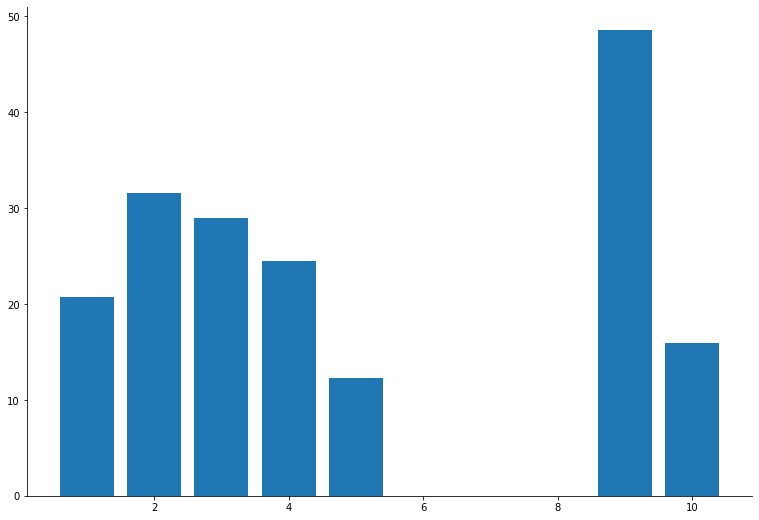

In [284]:
#Tiempo medio por cohorte de fuente

dias_a_primera_compra_por_usuario = pd.merge(dias_a_primera_compra_por_usuario,visitas[visitas['first_date']==visitas['date']][['uid','source_id']], on='uid', how='left')

display(dias_a_primera_compra_por_usuario.groupby('source_id').agg({'dias_a_primera_compra': ['mean','count']}))

plt.figure(figsize=(13, 9))
ax= plt.subplot()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.bar(dias_a_primera_compra_por_usuario.groupby('source_id').agg({'dias_a_primera_compra': 'mean'}).reset_index()['source_id'],
       dias_a_primera_compra_por_usuario.groupby('source_id').agg({'dias_a_primera_compra': 'mean'}).reset_index()['dias_a_primera_compra'])
plt.show()

Aquí podemos observar que, ignorando el caso de la fuente 7, que resulta irrelevante al contar con sólo un evento, las fuentes 5, 10 y 1 están llevando a un convencimiento rápido de la clientela a realizar su primera compra. Habría que estudiar sus tácticas.

Procederemos a evaluar las compras promedio tras cada mes de manera general y por cada una de las distintas cohortes. Para esto comenzaremos obteniendo el mes de cada compra y añadiremos las cohortes de los usuarios para fuente y dispositivo inicial.

In [285]:
#Obtener mes de cada compra, mes de primer compra y cohortes

pedidos['buy_month'] = pedidos['buy_date'].astype('datetime64[M]')
pedidos['first_date_month'] = pedidos['first_date'].astype('datetime64[M]')
pedidos = pd.merge(pedidos,visitas[visitas['first_date']==visitas['date']][['uid','device']], on='uid', how='left')
pedidos = pd.merge(pedidos,visitas[visitas['first_date']==visitas['date']][['uid','source_id']], on='uid', how='left')

display(pedidos.head())

,buy_ts,revenue,uid,buy_date,primera_compra,first_date,dias_a_primera_compra,buy_month,first_date_month,device,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,desktop,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,desktop,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,desktop,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,desktop,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,desktop,3


Para tener una idea de las ventas sin división por cohortes, primero realizaremos un gráfico de línea para ver su comportamiento a lo largo de los meses.

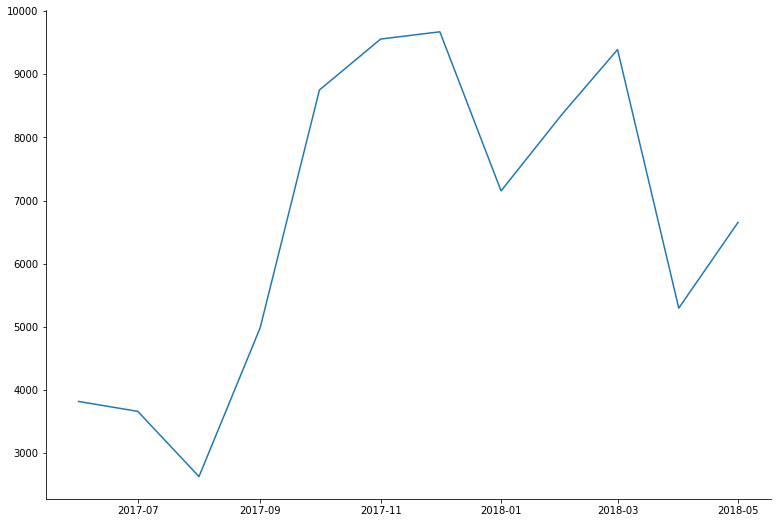

In [291]:
plt.figure(figsize=(13, 9))
ax= plt.subplot()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot(pedidos[pedidos['buy_month']!='2018-06-01'].groupby('buy_month').agg({'buy_ts':'count'}).reset_index()['buy_month'],
       pedidos[pedidos['buy_month']!='2018-06-01'].groupby('buy_month').agg({'buy_ts':'count'}).reset_index()['buy_ts'])
plt.show()

Podemos observar que en general, en cuanto a ventas, a pesar del pico en marzo hay una tendencia general a la baja, despues del rápido crecimiento inicial.

Ahora veamos la evolución por cohortes

In [286]:
#Agrupación de los cohortes por primera sesión y compra

cohort_grouped_compras_sesion = pedidos.groupby(
    ['first_date_month', 'buy_month']
).agg({'uid': 'nunique','device':'count','revenue':'sum'}).reset_index()

#Agregar columnas de promedios para cantidad de compras y ganancias

cohort_grouped_compras_sesion['compras_promedio']=cohort_grouped_compras_sesion['device']/cohort_grouped_compras_sesion['uid']
cohort_grouped_compras_sesion['ganancias_promedio']=cohort_grouped_compras_sesion['revenue']/cohort_grouped_compras_sesion['uid']

#Obtener columna de meses a compra
cohort_grouped_compras_sesion['cohort_lifetime'] = (
    cohort_grouped_compras_sesion['buy_month']
    - cohort_grouped_compras_sesion['first_date_month']
)/ np.timedelta64(1, 'M')

#Redondeamos por el factor de mes que crea decimales
cohort_grouped_compras_sesion['cohort_lifetime'] = (
    cohort_grouped_compras_sesion['cohort_lifetime'].round().astype('int')
)

#Corrección fomrato cohortes
cohort_grouped_compras_sesion['first_date_month']=cohort_grouped_compras_sesion['first_date_month'].dt.strftime('%Y-%m')


display(cohort_grouped_compras_sesion.head(15))

,first_date_month,buy_month,uid,device,revenue,compras_promedio,ganancias_promedio,cohort_lifetime
0,2017-06,2017-06-01,1988,3821,19377.14,1.922032,9.747052,0
1,2017-06,2017-07-01,208,582,4071.89,2.798077,19.576394,1
2,2017-06,2017-08-01,121,396,1938.95,3.272727,16.024380,2
3,2017-06,2017-09-01,173,643,6747.64,3.716763,39.003699,3
4,2017-06,2017-10-01,231,777,7345.50,3.363636,31.798701,4
5,2017-06,2017-11-01,191,636,3563.41,3.329843,18.656597,5
6,2017-06,2017-12-01,173,797,6268.47,4.606936,36.233931,6
7,2017-06,2018-01-01,144,528,4223.69,3.666667,29.331181,7
8,2017-06,2018-02-01,159,572,3739.70,3.597484,23.520126,8
9,2017-06,2018-03-01,147,540,5997.89,3.673469,40.801973,9


<AxesSubplot:title={'center':'Compras promedio por cliente'}, xlabel='cohort_lifetime', ylabel='first_date_month'>

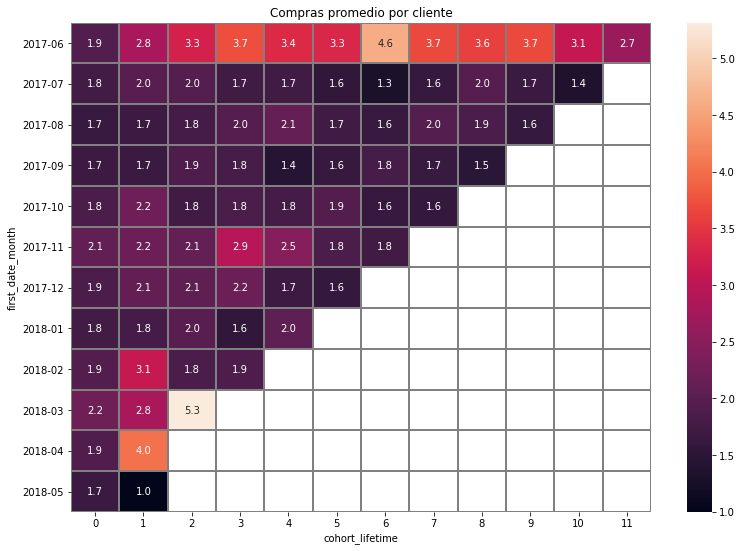

In [287]:
#Creación de heatmap sobre el comportamiento de compras de las cohortes

compras_por_usuario_sesion_pivot = cohort_grouped_compras_sesion.pivot_table(
    index='first_date_month',
    columns='cohort_lifetime',
    values='compras_promedio',
    aggfunc='mean',
)

plt.figure(figsize=(13, 9))
plt.title('Compras promedio por cliente')
sns.heatmap(
    compras_por_usuario_sesion_pivot,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
) 

Podemos observar un comportamiento muy similar al heatmap por cohortes de mes de primera sesión, donde la primer cohorte destaca sobre el resto, aunque esta vez la segunda y la tercea no destacan con la ligera elevación. Esto en general nos habla de que el radio entre visitas y compras es bastante constante.

Otro aspecto a observar en el heatmap es que en el antepenúltimo mes, que corresponde a marzo 2018, existió una elevación general de las compras independiente del cohorte, e igualmente dio lugar al cohorte con más compras en el primer mes. Es importante estudiar porqué marzo tuvo estos efectos.

A continuación se realizará un análisis similar con cohortes por dispositivo.

<AxesSubplot:title={'center':'Compras promedio por cliente'}, xlabel='buy_month', ylabel='device'>

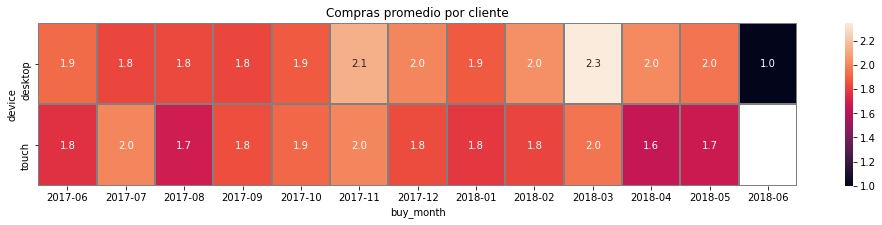

In [288]:
#Agrupación de los cohortes por dispositivo y compra

cohort_grouped_compras_device = pedidos.groupby(
    ['device', 'buy_month']
).agg({'uid': 'nunique','first_date_month':'count','revenue':'sum'}).reset_index()

#Agregar columnas de promedios para cantidad de compras y ganancias

cohort_grouped_compras_device['compras_promedio']=cohort_grouped_compras_device['first_date_month']/cohort_grouped_compras_device['uid']
cohort_grouped_compras_device['ganancias_promedio']=cohort_grouped_compras_device['revenue']/cohort_grouped_compras_device['uid']

#Corrección fomrato para mes
cohort_grouped_compras_device['buy_month']=cohort_grouped_compras_device['buy_month'].dt.strftime('%Y-%m')

#Creación de heatmap sobre el comportamiento de compras de las cohortes

compras_por_usuario_device_pivot = cohort_grouped_compras_device.pivot_table(
    index='device',
    columns='buy_month',
    values='compras_promedio',
    aggfunc='mean',
)

plt.figure(figsize=(17, 3))
plt.title('Compras promedio por cliente')
sns.heatmap(
    compras_por_usuario_device_pivot,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
) 

Podemos observar que las compras promedio, aunque no indistintas, son bastante similares entre los dispositivos, teniendo el desktop una ligera ventaja, la cual crece en los ultimos meses; resultará importante revisar si existió algún cambio desde abril en la presentación de la página para los dispositivos touch.

Finalmente realizaremos el mismo estudio para los cohortes por fuente:

<AxesSubplot:title={'center':'Compras promedio por cliente'}, xlabel='buy_month', ylabel='source_id'>

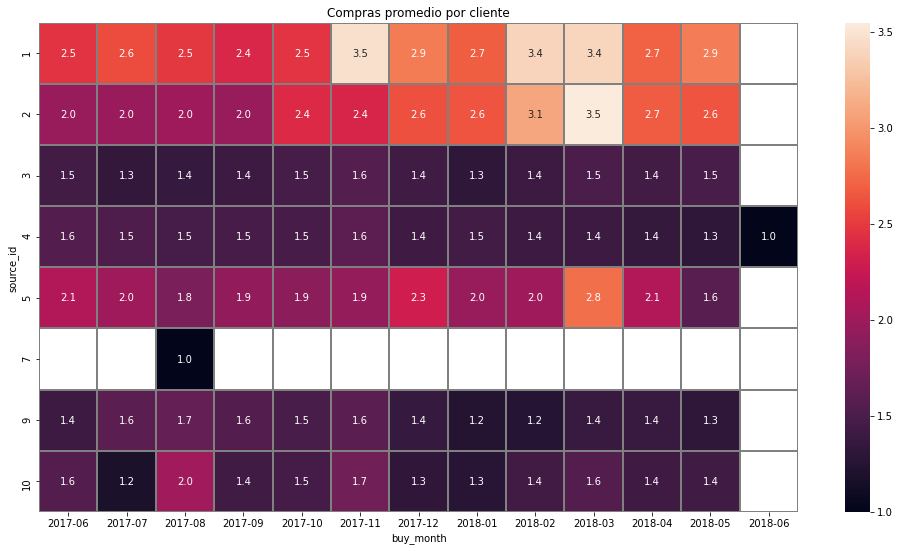

In [289]:
#Agrupación de los cohortes por fuente y compra

cohort_grouped_compras_fuente = pedidos.groupby(
    ['source_id', 'buy_month']
).agg({'uid': 'nunique','first_date_month':'count','revenue':'sum'}).reset_index()

#Agregar columnas de promedios para cantidad de compras y ganancias

cohort_grouped_compras_fuente['compras_promedio']=cohort_grouped_compras_fuente['first_date_month']/cohort_grouped_compras_fuente['uid']
cohort_grouped_compras_fuente['ganancias_promedio']=cohort_grouped_compras_fuente['revenue']/cohort_grouped_compras_fuente['uid']

#Corrección fomrato para mes
cohort_grouped_compras_fuente['buy_month']=cohort_grouped_compras_fuente['buy_month'].dt.strftime('%Y-%m')

#Creación de heatmap sobre el comportamiento de compras de las cohortes

compras_por_usuario_fuente_pivot = cohort_grouped_compras_fuente.pivot_table(
    index='source_id',
    columns='buy_month',
    values='compras_promedio',
    aggfunc='mean',
)

plt.figure(figsize=(17, 9))
plt.title('Compras promedio por cliente')
sns.heatmap(
    compras_por_usuario_fuente_pivot,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
) 

Claramente las fuentes 1, 2 y 5 son claramente las que terminaron convenciendo más a los clientes de llevar un comportamiento constante de compra, mientras que para las 3, 4, 9 y 10 será importante ubicar sus áreas de oportunidad.

Ahora realizaremos un analisis similar pero con el volumen promedio de venta. Utilizaremos las mismas tablas creadas para la cantidad de compras, para la cuales en su realización ya consideramos los ingresos. Comenzando por cohortes divididos por primer inicio de sesión.

<AxesSubplot:title={'center':'Ingresos - cohorte por fuente'}, xlabel='buy_month', ylabel='source_id'>

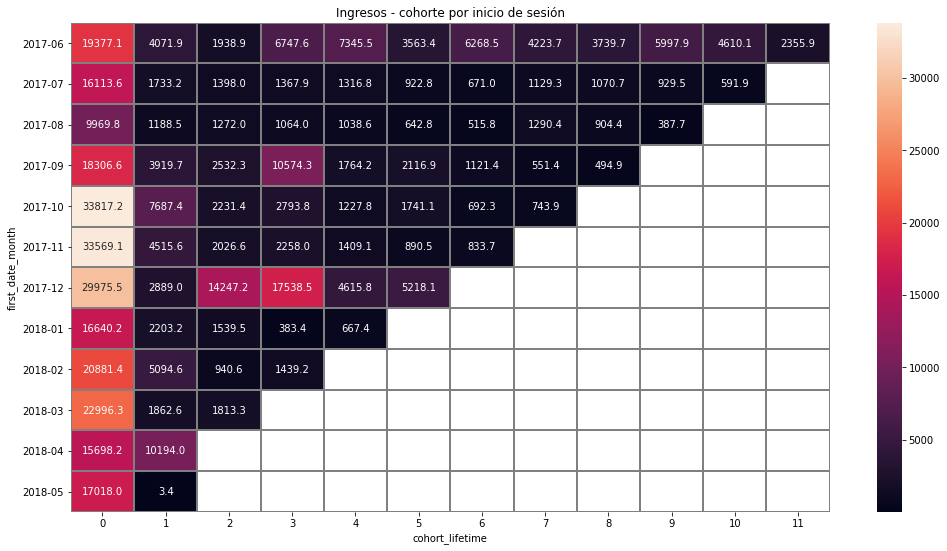

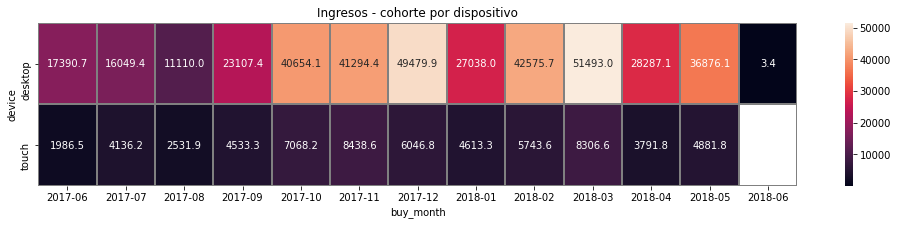

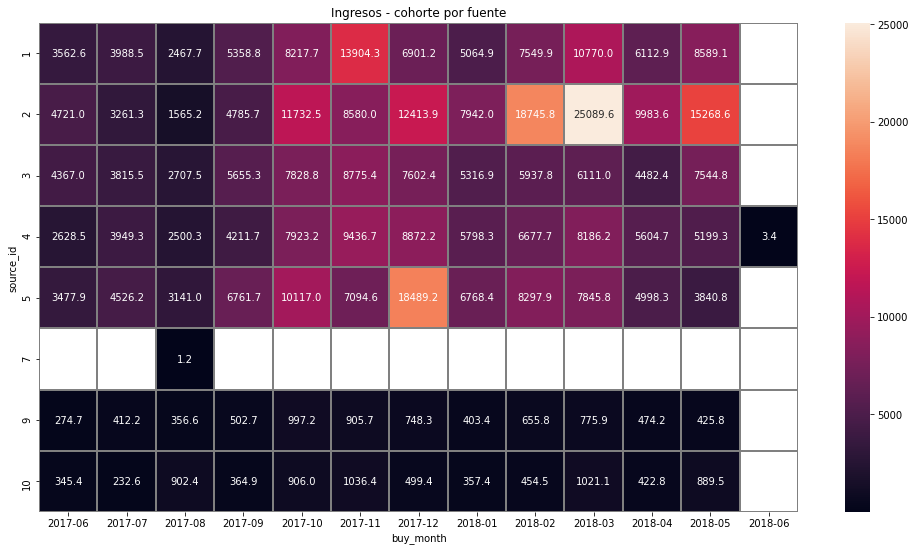

In [387]:
#Creación de heatmap sobre el comportamiento de Ingresos de las cohortes

ganancias_sesion_pivot = cohort_grouped_compras_sesion.pivot_table(
    index='first_date_month',
    columns='cohort_lifetime',
    values='revenue',
    aggfunc='mean',
)

plt.figure(figsize=(17, 9))
plt.title('Ingresos - cohorte por inicio de sesión')
sns.heatmap(
    ganancias_sesion_pivot,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
) 

#Creación de heatmap sobre el comportamiento de Ingresos de las cohortes por dispositivo

ganancias_device_pivot = cohort_grouped_compras_device.pivot_table(
    index='device',
    columns='buy_month',
    values='revenue',
    aggfunc='mean',
)

plt.figure(figsize=(17, 3))
plt.title('Ingresos - cohorte por dispositivo')
sns.heatmap(
    ganancias_device_pivot,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
) 

#Creación de heatmap sobre el comportamiento de Ingresos de las cohortes

ganancias_fuente_pivot = cohort_grouped_compras_fuente.pivot_table(
    index='source_id',
    columns='buy_month',
    values='revenue',
    aggfunc='mean',
)

plt.figure(figsize=(17, 9))
plt.title('Ingresos - cohorte por fuente')
sns.heatmap(
    ganancias_fuente_pivot,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
) 

En cuanto a los ingresos por cohorte se destaca sobremanera cómo cada cohorte en su primer mes es en el que más gasta, teniendo aparte de esto el los de junio y diciembre 2017 una mayor tendencia a generar ingresos. Siendo el de diciembre especialmente interesante ya que el consumo de los últimos meses destaca indudablemente.

En cuanto a los dispositivos, claramente entran muchos más ingresos por medio de dispositivos de escritorio, generando cada mes tres o cuatro veces los ingresos.

Finalmente respecto a las fuentes, es evidente como los primeros meses, independiente de la fuente, fueron los de menos ingresos. Así como el hecho de que las fuentes 9 y 10 no son significativos en el ingreso general.

Finalmente veamos cuánto dinero trae cada cohorte con el LTV. Que provendrá de una tabla y heatmap de ingresos promedio por usuario, pero se necesitan multiplicar estos por un margen de ingresos, que en este caso será considerado como de 0.5, y sumando los totales para cada cohorte.

<AxesSubplot:title={'center':'Ingresos promedio por cliente - cohorte por fuente'}, xlabel='buy_month', ylabel='source_id'>

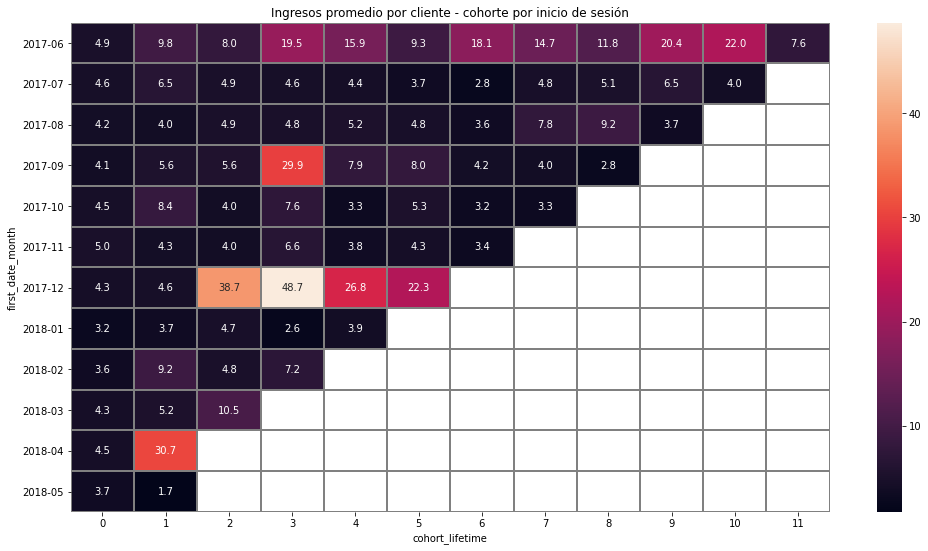

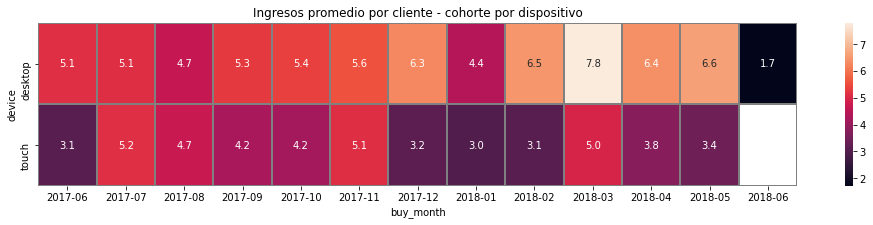

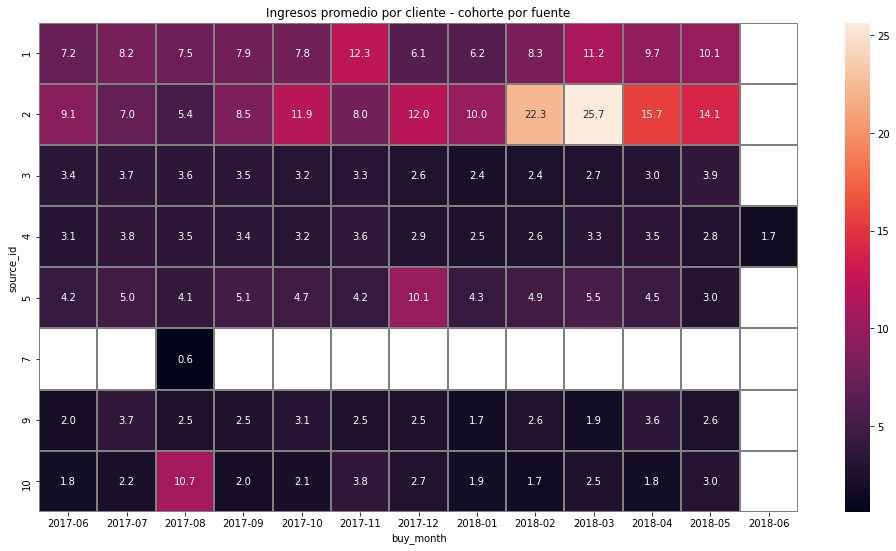

In [388]:
#Aplicar margen de ganancia a ingresos promedio por usuario
cohort_grouped_compras_sesion['ganancias_promedio']=cohort_grouped_compras_sesion['ganancias_promedio']*0.5
cohort_grouped_compras_device['ganancias_promedio']=cohort_grouped_compras_device['ganancias_promedio']*0.5
cohort_grouped_compras_fuente['ganancias_promedio']=cohort_grouped_compras_fuente['ganancias_promedio']*0.5


#Creación de heatmap sobre el comportamiento de Ingresos de las cohortes

ganancias_por_usuario_sesion_pivot = cohort_grouped_compras_sesion.pivot_table(
    index='first_date_month',
    columns='cohort_lifetime',
    values='ganancias_promedio',
    aggfunc='mean',
)

plt.figure(figsize=(17, 9))
plt.title('Ingresos promedio por cliente - cohorte por inicio de sesión')
sns.heatmap(
    ganancias_por_usuario_sesion_pivot,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
) 

#Creación de heatmap sobre el comportamiento de Ingresos de las cohortes por dispositivo

ganancias_por_usuario_device_pivot = cohort_grouped_compras_device.pivot_table(
    index='device',
    columns='buy_month',
    values='ganancias_promedio',
    aggfunc='mean',
)

plt.figure(figsize=(17, 3))
plt.title('Ingresos promedio por cliente - cohorte por dispositivo')
sns.heatmap(
    ganancias_por_usuario_device_pivot,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
) 

#Creación de heatmap sobre el comportamiento de Ingresos de las cohortes

ganancias_por_usuario_fuente_pivot = cohort_grouped_compras_fuente.pivot_table(
    index='source_id',
    columns='buy_month',
    values='ganancias_promedio',
    aggfunc='mean',
)

plt.figure(figsize=(17, 9))
plt.title('Ingresos promedio por cliente - cohorte por fuente')
sns.heatmap(
    ganancias_por_usuario_fuente_pivot,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
) 

Podemos observar muy claramente que estos heatmaps no se comportan como los de compras, lo que indica que no hay un radio constante entre las compras y las ganancias recibidas de las mismas. Que aunque el primer cohorte por inicio de sesión sigue manteniendo la delantera sobre la mayoría de los demás cohortes, destaca el cohorte de diciembre del 17, que ha sido el que más ha gastado en los últimos meses. Será útil visualizar de qué ventajas gozan los usuarios de esta cohorte.

En cuanto a los dispositivos, es clara la ventaja en ganancias de los desktop mes con mes, y en la mayoría duplicando los ingresos. Será importante analizar los incentivos de estos dispositivos sobre los touch a realizar un mayor gasto.

Finalmente, respecto a las fuentes, el cambio no fue demasiado notorio, únicamente cayendo un poco más la fuente 5 respecto a las 1 y 2.

A continuación calcularemos el LTV para cada cohorte:

In [389]:
print('LTV por cohorte de primer inicio de sesión')
display(cohort_grouped_compras_sesion.groupby('first_date_month').agg({'ganancias_promedio':'sum'}))
print()
print('LTV por cohorte de dispositivo')
display(cohort_grouped_compras_device.groupby('device').agg({'ganancias_promedio':'sum'}))
print()
print('LTV por cohorte de fuente')
display(cohort_grouped_compras_fuente.groupby('source_id').agg({'ganancias_promedio':'sum'}))
print()

LTV por cohorte de primer inicio de sesión


,ganancias_promedio
first_date_month,
2017-06,161.899518
2017-07,51.946096
2017-08,52.273361
2017-09,71.901594
2017-10,39.644257
2017-11,31.321176
2017-12,145.488047
2018-01,18.037101
2018-02,24.887404



LTV por cohorte de dispositivo


,ganancias_promedio
device,
desktop,70.842847
touch,47.925971



LTV por cohorte de fuente


,ganancias_promedio
source_id,
1,102.405746
2,149.667838
3,37.627557
4,39.923970
5,59.629343
7,0.610000
9,31.393685
10,36.253572


Con estos LTV, podemos confirmar lo observado en los heatmaps:
* Clara ventaja de los dispositivos desktop
* Clara ventaja de las fuentes 1 y 2
* Comportamiento inusualmente elevado de quienes iniciaron sesión por primera vez en junio y diciembre de 2017

## Marketing

Finalmente analizaremos el efecto del marketing en las ventas y ganancias de la empresa, para lo que se responderán las siguientes preguntas:

* ¿Cuánto dinero se gastó? Total/por fuente/a lo largo del tiempo
* ¿Cuánto costó la adquisición de clientes de cada una de las fuentes?
* ¿Cuán rentables eran las inversiones? (ROI)

Para conocer cuánto se ha gastado por fuente a lo largo del tiempo, crearemos primero las columnas de mes y año para la tabla de gastos, y procederemos con la gráfica correspondiente.

<AxesSubplot:title={'center':'Gastos mensuales por fuente'}, xlabel='month', ylabel='source_id'>

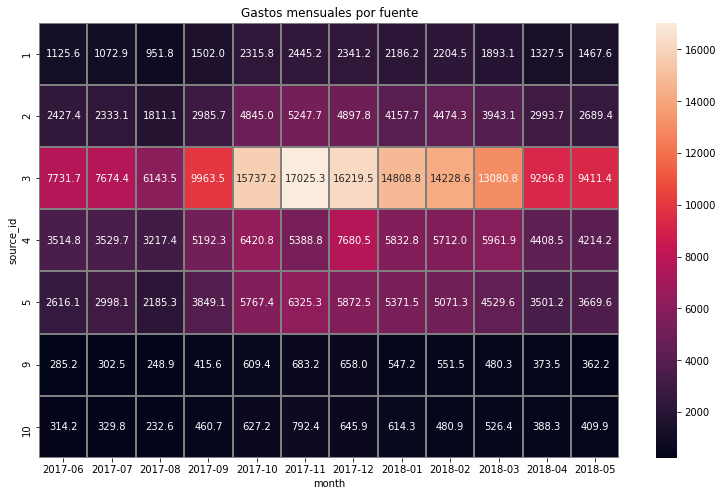

In [390]:
#Crear nuevas columnas para día

gastos['mk_date'] = gastos['dt'].dt.date
gastos['month'] = gastos['mk_date'].astype('datetime64[M]')

gastos['month']=gastos['month'].dt.strftime('%Y-%m')

#Gráfica de gastos por mes por fuente

gastos_source_mes = gastos.pivot_table(index='source_id', columns='month', values='costs', aggfunc='sum')

plt.figure(figsize=(13, 8))
plt.title('Gastos mensuales por fuente')
sns.heatmap(
    gastos_source_mes,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
) 

Para conocer cuánto costó la adquisisión de cada cliente por fuente vamos a considerar el día de la primera visita de las cohortes que nos hemos encontrado estudiando, las cuales son las más representativas, al tratarse de las que han retornado y mayor impacto tienen en las ventas. Se considerará el día de su primera visita como la captación del usuario ya que sabemos que a partir de esta se generó una compra y fue en esta fecha que los gastos de marketing tuvieron su verdadero efecto.

<AxesSubplot:title={'center':'Clientes nuevos mensuales por fuente'}, xlabel='first_date_month', ylabel='source_id'>

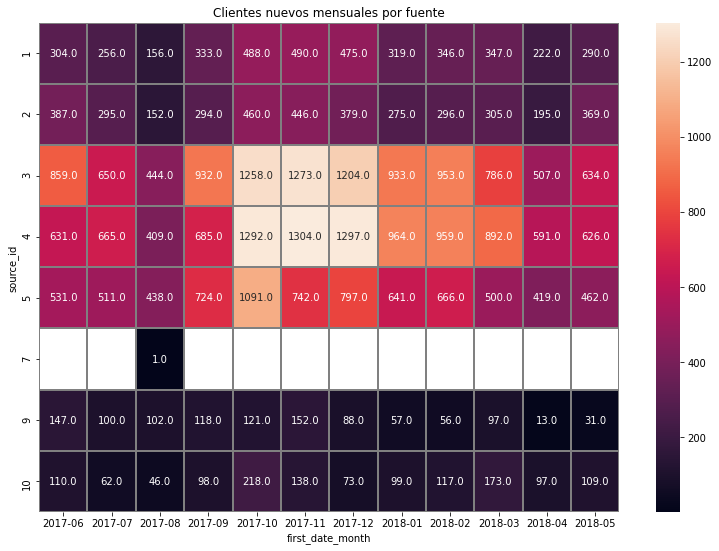

In [391]:
#Cambiar formato de cohorte de inicio de sesión

pedidos['first_date_month']=pedidos['first_date_month'].dt.strftime('%Y-%m')

#Crear tabla de nuevos inicios por mes

nuevos_clientes_mes = pedidos.pivot_table(index='source_id', columns='first_date_month', values='uid', aggfunc='nunique')

plt.figure(figsize=(13, 9))
plt.title('Clientes nuevos mensuales por fuente')
sns.heatmap(
    nuevos_clientes_mes,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
) 

<AxesSubplot:title={'center':'Costo de cliente nuevo mensuales por fuente'}, xlabel='month', ylabel='source_id'>

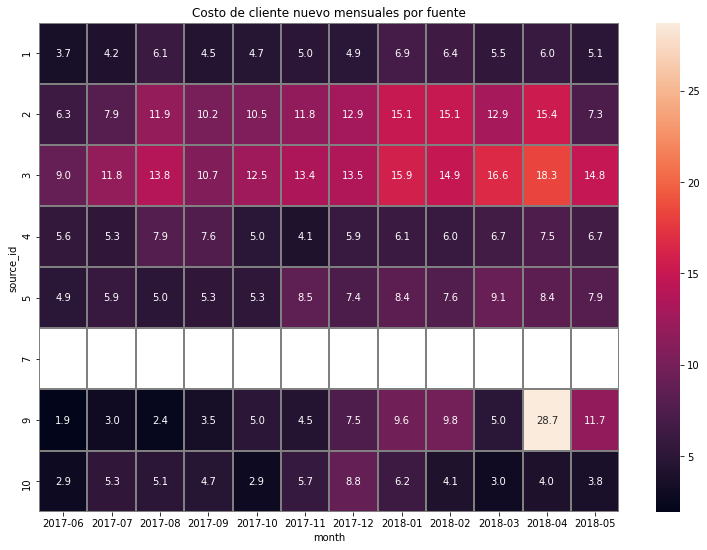

In [392]:
#Para observar cuánto costó la adquisición de estos clientes realizaremos el cálculo correspondiente entre ambos datos

plt.figure(figsize=(13, 9))
plt.title('Costo de cliente nuevo mensuales por fuente')
sns.heatmap(
    gastos_source_mes/nuevos_clientes_mes,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
) 

Podemos observar que en general los usuarios más caros son los que corresponden a los de la fuente 3, aunque puede que a la larga sea la mejor invesrión dado que hemos observado que también se trata de la fuente que representa la mayor cantidad de nuevos usuarios.

Y para revisar cuán rentables resultan estas invesriones, finalmente analizaremos los ingresos provistos por cada uno de estos clientes y los compararemos con el gasto realizado en adquirirlos.

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Excelente trabajo, Alejandro.
    
</div>

<AxesSubplot:title={'center':'ROI mensual por fuente'}, xlabel='first_date_month', ylabel='source_id'>

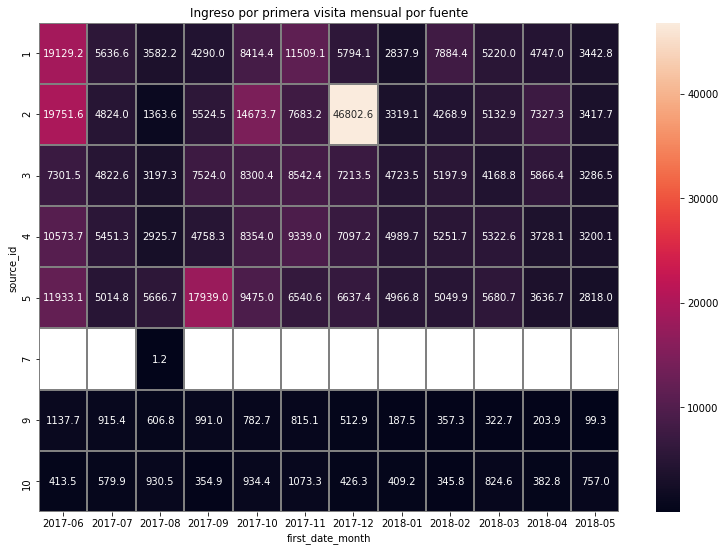

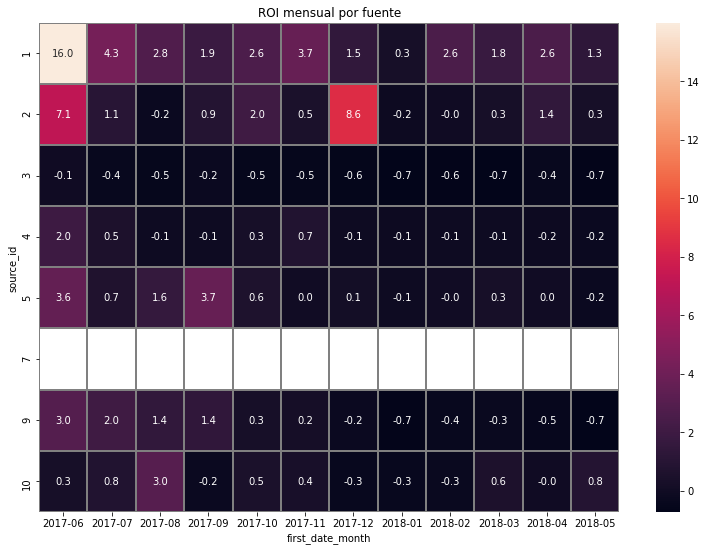

In [393]:
#Obtenemos primero los ingresos por mes de primera visita de los usuarios
ingresos_nuevos_clientes_mes = pedidos.pivot_table(index='source_id', columns='first_date_month', values='revenue', aggfunc='sum')

#Graficamos tabla de ingresos
plt.figure(figsize=(13, 9))
plt.title('Ingreso por primera visita mensual por fuente')
sns.heatmap(
    ingresos_nuevos_clientes_mes,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
) 

#Graficamos la tabla de ROI
plt.figure(figsize=(13, 9))
plt.title('ROI mensual por fuente')
sns.heatmap(
    (ingresos_nuevos_clientes_mes-gastos_source_mes)/gastos_source_mes,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
) 


Finalmente observamos que ese gasto extra en la adquisición de usuarios de la tercera fuente no representa un beneficio a la larga ya que se está perdiendo dinero, mientras que la primera fuente, mucho más económica es de la que se obtiene una mejor relación entre el gasto y las ganancias.

# 4 Conclusiones generales

Tras haber realizado inicialmente una evaluación por cohortes respecto al día de su primer acceso a la plataforma, así como otros cohortes por dispositivos y por fuente, pudimos observar que existe una gran diferencia en comportamientos de cantidad de visitas, compras y dinero gastado para las cohortes de junio y diciembre de 2017, es muy imoprtante estudiar qué es lo que mantiene a los primeros usuarios, y qué está provocando que los de diciembre estén aumentando sus consumos. Igualmente resulta interesante que, respecto a los dispositivos, quienes usan desktop, a pesar de realizar un número de compras similar a los que utilizan touch, sus niveles de gasto son mucho mayores; indicando la existencia de incentivos ya sea visuales o promocionales que en los equipos desktop están teniendo un muy buen efecto.

Otro fenómeno que pudo observarse gracias a las gráficas es que, aunque los ingresos de los primeros meses son menores a los posteriores, los clientes visitan y gastan cada vez menos. Es necesario llevar a cabo estrategias de retención de clientes, que evite la persistencia de este fenómeno.

Posteriormente realizando un análisis sobre los gastos de marketing, pudimos confirmar que aunque la fuente 3 es la que más nuevos representa, al final del día no es tan rentable dados los gastos de marketing por conseguir usuarios de esta fuente. Podría ser recomendable realizar algunos estudios aumentando los gastos en las fuentes 4 y 5, que aunque no son las que representan los mayores ingresos sí representan los mayores pedidos y no se les invierte tanto por el momento. 
Mientras que no se recomienda seguir invirtiendo en las fuentes nueve y 10 que generan pérdidas y prácticamente ningún ingreso.